# **Contradictory, My Dear Watson: Multi-Model Classification Write-Up**

---

## 1. Introduction

Textual Entailment (also known as Natural Language Inference, or NLI) is a core task in Natural Language Processing (NLP) that involves determining whether a given *hypothesis* can be inferred from a *premise*. Specifically, the relationship is categorized as **entailment**, **contradiction**, or **neutrality**.

In the [“Contradictory, My Dear Watson”](https://www.kaggle.com/competitions/contradictory-my-dear-watson) Kaggle competition, the challenge is to classify sentence pairs across multiple languages into one of these three classes. Our approach leverages powerful transformer-based models from the [Hugging Face](https://huggingface.co/) library. By fine-tuning several state-of-the-art multilingual models, we aim to determine which architecture best captures the nuances of cross-lingual textual entailment.

Here is a link to our [Github Repo](https://github.com/caseym7875/DSCI-478-Kaggle)

> **Notebook Outline:**  
> 1. Introduction  
> 2. Problem Description  
> 3. Model Selection  
> 4. Method / Code  
> 5. Conclusion  
> 6. References

---

## 2. Problem Description

The task at hand involves analyzing pairs of sentences, where each pair consists of:
- A **premise**: a given sentence or statement.
- A **hypothesis**: another sentence that may or may not be logically inferred from the premise.
- A **label**: indicating whether the hypothesis is in **entailment**, **contradiction**, or **neutral** relation with the premise.

This problem is inherently challenging due to its multilingual nature, with data drawn from 15 different languages. The cross-lingual aspect demands models that can robustly capture semantic relationships despite linguistic diversity. By formulating this as a three-class classification problem, we can systematically evaluate the performance of various pretrained transformer models on their ability to generalize across languages.

---

## 3. Model Selection and Tokenization Details

In our experiments, we compare three prominent multilingual transformer models based on BERT: 

![BertImage](https://raw.githubusercontent.com/caseym7875/DSCI-478-Kaggle/refs/heads/main/BERT.png)

### 1. **XLM-RoBERTa**  
XLM-RoBERTa, as introduced in [Conneau et al., 2020](https://arxiv.org/abs/1911.02116), is designed for robust cross-lingual performance. 
- XLM-R is a multilingual variant of RoBERTa, trained on **100 languages** using the **CC-100 corpus**.
- Its architecture and training procedure enable it to capture nuanced semantic relationships across languages, which is critical for tasks like textual entailment.


### 2. **Multilingual BERT (mBERT)**  
Multilingual BERT, detailed in [Devlin et al., 2019](https://arxiv.org/abs/1810.04805), supports 104 languages using a shared WordPiece vocabulary.
- Trained on the **Wikipedia corpora of 104 languages**, making it highly effective for multilingual tasks.
- Retains the Next Sentence Prediction (NSP) task, which may be useful for certain textual inference problems.
- Despite being an earlier model, it remains a **strong baseline** for multilingual NLP.

### 3. **mDeBERTa**  
mDeBERTa is an extension of the DeBERTa architecture as described in [He et al., 2021](https://arxiv.org/abs/2006.03654).
- Introduces a **disentangled attention mechanism** that separately encodes content and positional embeddings, enhancing contextual learning.
- Incorporates an **enhanced mask decoder**, helping it outperform standard BERT-based models on classification tasks.
- Demonstrates strong performance on multilingual tasks due to diverse pretraining.
  

> ### Model Summary
> All four models restrict inputs to a **512-token limit**, ensuring computational feasibility. However, their tokenization strategies differ slightly:
> - **XLM-RoBERTa** and **mDeBERTa** both use SentencePiece/BPE tokenization, emphasizing efficiency in subword representation.
> - **mBERT** relies on WordPiece tokenization, which tends to produce more granular subword units.
>
> In terms of overall performance for our multilingual NLI task:
> - **XLM-RoBERTa** is expected to excel due to its superior cross-lingual representations.
> - **mBERT** provides a strong baseline, though it is slightly older.
> - **mDeBERTa** benefits from improved attention mechanisms.
>
> Further fine-tuning and hyperparameter optimization tailored to each model could yield additional improvements in classification performance.

## 3. Method / Code

#### Cell 1: Environment Setup


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil 
from transformers import AutoTokenizer, TFAutoModel
from tensorflow import keras
from IPython.display import clear_output, display

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('Setup complete!')

Setup complete!


#### Cell 2: Loading the Dataset

Train shape: (12120, 6)
Test shape: (5195, 5)

Average premise length (in words): 17.99
Average hypothesis length (in words): 9.20

Max premise length (in words): 196.00
Max hypothesis length (in words): 46.00


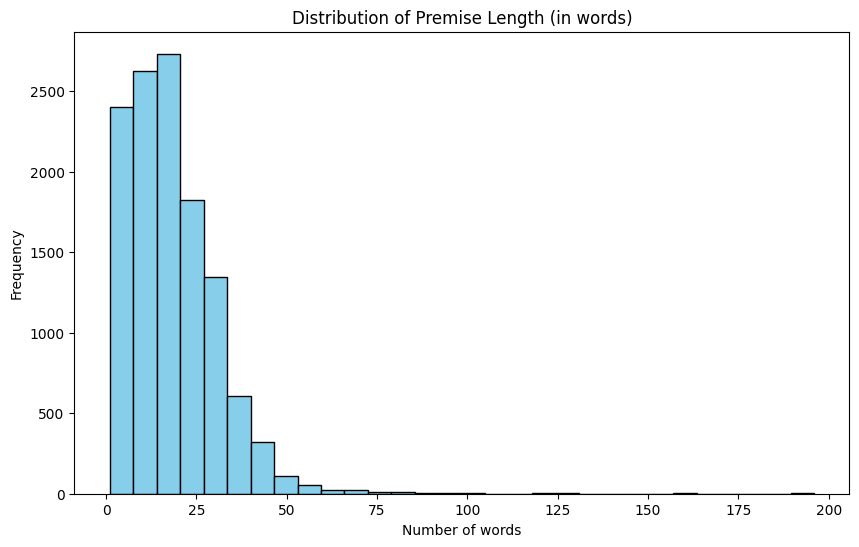

In [3]:
train_data = pd.read_csv(
    "https://raw.githubusercontent.com/caseym7875/DSCI-478-Kaggle/refs/heads/main/train.csv"
)
test_data = pd.read_csv(
    "https://raw.githubusercontent.com/caseym7875/DSCI-478-Kaggle/refs/heads/main/test.csv"
)

print('Train shape:', train_data.shape)
print('Test shape:', test_data.shape)
train_data.head()

"""
Determine appropriate token size
"""

# Calculate average word count for premises and hypotheses
avg_premise_length = train_data['premise'].apply(lambda x: len(x.split())).mean()
avg_hypothesis_length = train_data['hypothesis'].apply(lambda x: len(x.split())).mean()

max_premise_length = train_data['premise'].apply(lambda x: len(x.split())).max()
max_hypothesis_length = train_data['hypothesis'].apply(lambda x: len(x.split())).max()

print("\nAverage premise length (in words): {:.2f}".format(avg_premise_length))
print("Average hypothesis length (in words): {:.2f}".format(avg_hypothesis_length))

print("\nMax premise length (in words): {:.2f}".format(max_premise_length))
print("Max hypothesis length (in words): {:.2f}".format(max_hypothesis_length))

premise_lengths = train_data['premise'].apply(lambda x: len(x.split()))

# Plot the distribution of premise lengths
plt.figure(figsize=(10,6))
plt.hist(premise_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Premise Length (in words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

The relatively low average word counts in our dataset indicate that using the standard 512-token limit is excessive. To conserve computational resources and reduce processing time, we have set the maximum token length to 128 tokens (defined in next cell). While this does omit some outliers, it should save on computation.

#### Cell 3: Defining Helper Functions

In [4]:


def tokenize_data(model_name, dataframe, max_len=256):
    """
    Loads a tokenizer for a given model and tokenizes premise/hypothesis text to numerical IDs using the specified model.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    encodings = tokenizer(
        list(dataframe['premise'].values),
        list(dataframe['hypothesis'].values),
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='tf'
    )
    return encodings

def build_model(model_name, max_len=128, num_labels=3, lr=2e-5, dropout_rate=0.3):
    """
    Create a Keras model using TFAutoModel + a simple classification head.
    """
    base_model = TFAutoModel.from_pretrained(model_name)
    input_ids      = keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    
    outputs = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    cls_token = outputs.last_hidden_state[:, 0, :]
    
    x = keras.layers.Dropout(dropout_rate)(cls_token)
    x = keras.layers.Dense(num_labels, activation='softmax')(x)
    
    model = keras.Model(inputs=[input_ids, attention_mask], outputs=x)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def plot_history(history, title_prefix=""):

    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)
    
    plt.figure(figsize=(10,4))
    
    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], 'bo-', label='Train Loss')
    if 'val_loss' in hist:
        plt.plot(epochs, hist['val_loss'], 'ro-', label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Sub-Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], 'bo-', label='Train Acc')
    if 'val_accuracy' in hist:
        plt.plot(epochs, hist['val_accuracy'], 'ro-', label='Val Acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Sub-Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

print("Helper functions defined.")

Helper functions defined.


#### Cell 4: Preparing Train/Validation Split
We shuffle the training data and split off 10% as a validation set to monitor performance.

In [5]:
VALIDATION_SPLIT = 0.1
val_size = int(len(train_data) * VALIDATION_SPLIT)

train_data_shuffled = train_data.sample(frac=1, random_state=SEED).reset_index(drop=True)

val_data = train_data_shuffled.iloc[:val_size]
train_data_ = train_data_shuffled.iloc[val_size:]

y_val = val_data['label'].values
y_train = train_data_['label'].values

print(f"Training set size: {len(train_data_)}")
print(f"Validation set size: {len(val_data)}")

Training set size: 10908
Validation set size: 1212


#### Cell 5: Training Multiple Models
We define a list of model candidates:
1. **XLM-RoBERTa**
2. **Multilingual BERT**
3. **mDeBERTa**

For each:
1. We **tokenize** train and validation data.
2. **Build** the Keras model.
3. **Train** for a specified number of epochs, using cross-entropy.
4. **Evaluate** on the validation set.
5. **Predict** on test data.
6. **Save** each model’s predictions to a CSV.

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['classifier.dense.weight', 'roberta.embeddings.position_ids', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Epoch 1/50
136/136 [==============================] - 213s 1s/step - loss: 0.4603 - accuracy: 0.8410 - val_loss: 0.3201 - val_accuracy: 0.8878
Epoch 2/50
136/136 [==============================] - 142s 1s/step - loss: 0.4245 - accuracy: 0.8612 - val_loss: 0.3039 - val_accuracy: 0.8837
Epoch 3/50
136/136 [==============================] - 142s 1s/step - loss: 0.4816 - accuracy: 0.8438 - val_loss: 0.3210 - val_accuracy: 0.8754
Epoch 4/50
136/136 [==============================] - 141s 1s/step - loss: 0.5161 - accuracy: 0.8290 - val_loss: 0.4219 - val_accuracy: 0.8457
Epoch 5/50
136/136 [==============================] - 141s 1s/step - loss: 0.4598 - accuracy: 0.8382 - val_loss: 0.3916 - val_accuracy: 0.8779
Epoch 6/50
136/136 [==============================] - 142s 1s/step - loss: 0.4611 - accuracy: 0.8327 - val_loss: 0.3485 - val_accuracy: 0.8795
Epoch 7/50
136/136 [==============================] - 142s 1s/step - loss: 0.4646 - accuracy: 0.8483 - val_loss: 0.3490 - val_accuracy: 0.8721

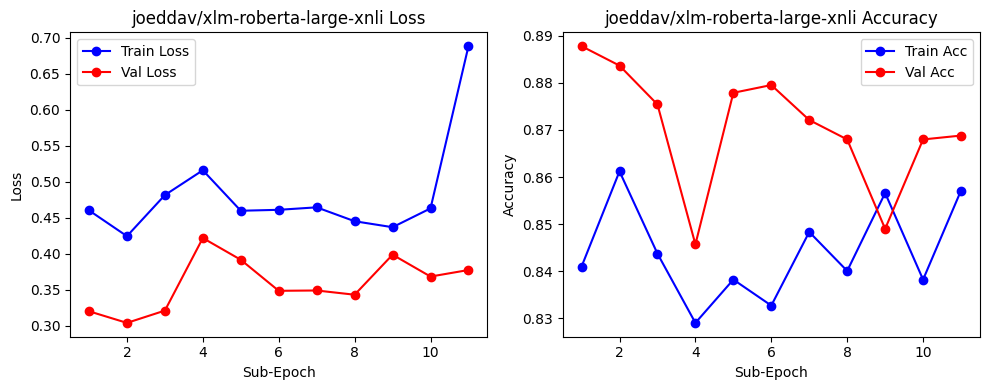

650/650 [==============================] - 164s 244ms/step


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/functional.py:641: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


136/136 [==============================] - 83s 368ms/step - loss: 1.1774 - accuracy: 0.3686 - val_loss: 1.1756 - val_accuracy: 0.3218
Epoch 2/50
136/136 [==============================] - 46s 342ms/step - loss: 1.1559 - accuracy: 0.3722 - val_loss: 0.9700 - val_accuracy: 0.5437
Epoch 3/50
136/136 [==============================] - 46s 338ms/step - loss: 1.0465 - accuracy: 0.4871 - val_loss: 0.9403 - val_accuracy: 0.5652
Epoch 4/50
136/136 [==============================] - 46s 341ms/step - loss: 1.0090 - accuracy: 0.5239 - val_loss: 0.8937 - val_accuracy: 0.5924
Epoch 5/50
136/136 [==============================] - 46s 339ms/step - loss: 1.0213 - accuracy: 0.5064 - val_loss: 0.8873 - val_accuracy: 0.5998
Epoch 6/50
136/136 [==============================] - 46s 340ms/step - loss: 0.9254 - accuracy: 0.5965 - val_loss: 0.9154 - val_accuracy: 0.6147
Epoch 7/50
136/136 [==============================] - 46s 341ms/step - loss: 0.9782 - accuracy: 0.5349 - val_loss: 0.8986 - val_accuracy: 0.6

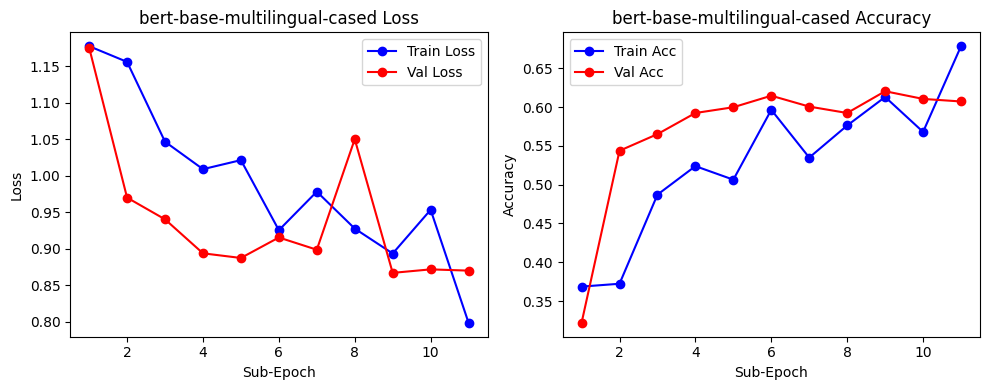

650/650 [==============================] - 56s 82ms/step


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


tf_model.h5:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/mdeberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/functional.py:641: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


136/136 [==============================] - 124s 577ms/step - loss: 1.2405 - accuracy: 0.3676 - val_loss: 1.0943 - val_accuracy: 0.3276
Epoch 2/50
136/136 [==============================] - 70s 519ms/step - loss: 1.2749 - accuracy: 0.3272 - val_loss: 1.0343 - val_accuracy: 0.4835
Epoch 3/50
136/136 [==============================] - 69s 508ms/step - loss: 1.0921 - accuracy: 0.4577 - val_loss: 0.7878 - val_accuracy: 0.6444
Epoch 4/50
136/136 [==============================] - 69s 506ms/step - loss: 0.7753 - accuracy: 0.6756 - val_loss: 0.6884 - val_accuracy: 0.7153
Epoch 6/50
136/136 [==============================] - 68s 503ms/step - loss: 0.7838 - accuracy: 0.6682 - val_loss: 0.6695 - val_accuracy: 0.7417
Epoch 7/50
136/136 [==============================] - 68s 499ms/step - loss: 0.7458 - accuracy: 0.6958 - val_loss: 0.6708 - val_accuracy: 0.7277
Epoch 8/50
136/136 [==============================] - 68s 499ms/step - loss: 0.7261 - accuracy: 0.7160 - val_loss: 0.6103 - val_accuracy: 0.

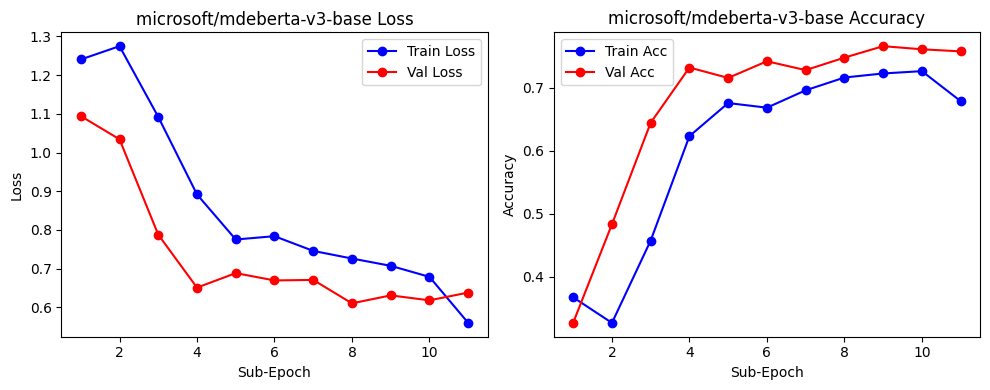

650/650 [==============================] - 72s 103ms/step


In [ ]:
model_candidates = [
    "joeddav/xlm-roberta-large-xnli",
    "bert-base-multilingual-cased",
    "microsoft/mdeberta-v3-base"
]

BATCH_SIZE = 8   
EPOCHS = 3       
MAX_LEN = 128   

results = {}               
predictions_dict = {}         
predictions_csv_dict = {}    
saved_model_paths = []       

for model_name in model_candidates:
    print(f"\n=== Training model: {model_name} ===")
    # Tokenize train & val
    train_encodings = tokenize_data(model_name, train_data_, max_len=MAX_LEN)
    val_encodings   = tokenize_data(model_name, val_data,   max_len=MAX_LEN)
    
    # Build TF Datasets
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((dict(train_encodings), y_train))
        .shuffle(buffer_size=len(train_data_))
        .batch(BATCH_SIZE)
    )
    
    val_dataset = (
        tf.data.Dataset
        .from_tensor_slices((dict(val_encodings), y_val))
        .batch(BATCH_SIZE)
    )
    
    # Calculate original steps and then split epochs into sub-epochs (for plotting)
    original_steps = len(list(train_dataset))
    subepochs_per_epoch = 10
    steps_per_subepoch = original_steps // subepochs_per_epoch
    total_subepochs = EPOCHS * subepochs_per_epoch 
    
    # Build model
    model = build_model(model_name, max_len=MAX_LEN)
    
    # Train
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=total_subepochs,
        steps_per_epoch=steps_per_subepoch,
        verbose=1
    )
    csv_path = f"History/{model_name.replace('/', '_')}_training_history.csv"
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(csv_path, index=False)
    
    plot_history(history, title_prefix=model_name)
    
    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(val_dataset, verbose=0)
    results[model_name] = val_acc
    print(f"Validation Accuracy for {model_name}: {val_acc:.4f}")
    
    # Predict on the test set
    test_encodings = tokenize_data(model_name, test_data, max_len=MAX_LEN)
    test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(BATCH_SIZE)
    test_preds = model.predict(test_dataset)
    test_labels = np.argmax(test_preds, axis=1)
    predictions_dict[model_name] = test_labels
    
    # Save model
    save_path = f"./{model_name.replace('/', '_')}_model"
    model.save(save_path)
    saved_model_paths.append(save_path)
    
    pred_csv_path = f"{model_name.replace('/', '_')}_predictions.csv"
    submission_df = pd.DataFrame({
        'id': test_data['id'],
        'prediction': test_labels
    })
    submission_df.to_csv(pred_csv_path, index=False)
    predictions_csv_dict[model_name] = pred_csv_path

#### Cell 6: Comparing & Saving Predictions
Here we:
1. Summarize each model’s validation accuracy.
2. Pick the **best** model.
3. Copy that model’s prediction CSV to **`submission.csv`** for Kaggle.


In [7]:
model_performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Val Accuracy': list(results.values()),
    'Prediction CSV': [predictions_csv_dict[m] for m in results.keys()]
}).sort_values(by='Val Accuracy', ascending=False)

print("=== Model Validation Performance ===")
display(model_performance_df)

best_model_name = model_performance_df.iloc[0]['Model']
best_model_csv = model_performance_df.iloc[0]['Prediction CSV']
print(f"\nBest Model: {best_model_name}")

shutil.copyfile(best_model_csv, "submission.csv")
print("\nFinal submission.csv created from the best model!")

=== Model Validation Performance ===


,Model,Val Accuracy,Prediction CSV
0,joeddav/xlm-roberta-large-xnli,0.868812,joeddav_xlm-roberta-large-xnli_predictions.csv
2,microsoft/mdeberta-v3-base,0.757426,microsoft_mdeberta-v3-base_predictions.csv
1,bert-base-multilingual-cased,0.607261,bert-base-multilingual-cased_predictions.csv



Best Model: joeddav/xlm-roberta-large-xnli

Final submission.csv created from the best model!


#### Cell 7: Compare Model Predictions
We can look at the first 10 predictions from each model side by side to see how they compare


In [8]:
comparison_df = pd.DataFrame()
comparison_df['test_id'] = test_data['id']
comparison_df['hypothesis'] = test_data['hypothesis']
comparison_df['premise'] = test_data['premise']

for model_name in model_candidates:
    comparison_df[model_name] = predictions_dict[model_name]

comparison_df.head()

,test_id,hypothesis,premise,joeddav/xlm-roberta-large-xnli,bert-base-multilingual-cased,microsoft/mdeberta-v3-base
0,c6d58c3f69,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,2,2,2
1,cefcc82292,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,هذا هو ما تم نصحنا به.,1,1,2
2,e98005252c,Les mères se droguent.,et cela est en grande partie dû au fait que le...,1,0,0
3,58518c10ba,IMA与其他组织合作，因为它们都依靠共享资金。,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,1,1,1
4,c32b0d16df,"Мы думали, что она ушла, однако, она осталась.",Она все еще была там.,1,0,2


### Training Plots:
(I didnt have a clean output when training so to improve the readibility of this report, I hid the training cell's output and saved/loaded the training plots, but I was only able to recover the first epoch.)

Here we can analyze the training process for each of the model and compare how they learn the data.

#### BERT
![BERT_training](https://raw.githubusercontent.com/caseym7875/DSCI-478-Kaggle/refs/heads/main/Plots/bert.png)
#### mDeBERTa
![mdberta_training](https://raw.githubusercontent.com/caseym7875/DSCI-478-Kaggle/refs/heads/main/Plots/mdeberta.png)
#### XLM-RoBERTa
![xlm_training](https://raw.githubusercontent.com/caseym7875/DSCI-478-Kaggle/refs/heads/main/Plots/xlm.png)

An interesting trend here is that XLM-RoBERTa performs worse as it is trained. This suggests that the model has very strong base performance, and our tuning is not teaching it anything new. It is likely that over training time, the validation would improve after the initial dip. **Overall, XLM-R ends up performing best on the validation set, while the other two also improve steadily but do not quite match XLM-R’s final accuracy.**

---

## 5. Conclusion

We have demonstrated a **multilingual classification** approach using pretrained transformers:
- **XLM-RoBERTa**
- **Multilingual BERT**
- **mDeBERTa**

Each was fine-tuned on the **Contradictory, My Dear Watson** dataset for 3 epochs, though **increasing** epochs usually improves final accuracy, we observed our best performing model **XLM-RoBERTa** emerged as the best performer. Interestingly, we observed that training XLM-RoBERTa for just 1 epoch (in another session) resulted in a validation score of 0.89, compared to 0.84 for 2 epochs under the same conditions—likely due to inherent variability in the training process. This suggests that additional training might yield only marginal improvements relative to the extra computational cost.

### Potential Improvements
- **Longer Training**: Exploring more epochs may help, provided that the validation performance eventually plateaus.
- **Hyperparameter Tuning**: Fine-tuning the learning rate, batch size, and other parameters could yield further gains.
- **Data Augmentation**: Incorporating more diverse or augmented training data could help improve robustness.

## 6. References

- **Vaswani et al., 2017**  
  *Attention Is All You Need.*  
  In *Advances in Neural Information Processing Systems (NIPS)*.  
  [https://arxiv.org/abs/1706.03762](https://arxiv.org/abs/1706.03762)

- **Devlin et al., 2019**  
  *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.*  
  In *North American Chapter of the Association for Computational Linguistics (NAACL)*.  
  [https://arxiv.org/abs/1810.04805](https://arxiv.org/abs/1810.04805)

- **Conneau et al., 2020**  
  *Unsupervised Cross-lingual Representation Learning at Scale.*  
  In *Annual Meeting of the Association for Computational Linguistics (ACL)*.  
  (XLM-RoBERTa)  
  [https://arxiv.org/abs/1911.02116](https://arxiv.org/abs/1911.02116)

- **He et al., 2021**  
  *DeBERTa: Decoding-Enhanced BERT with Disentangled Attention.*  
  In *International Conference on Learning Representations (ICLR)*.  
  [https://arxiv.org/abs/2006.03654](https://arxiv.org/abs/2006.03654)

- **Hugging Face Transformers**  
  [https://huggingface.co/docs/transformers](https://huggingface.co/docs/transformers)